In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# no necessary when using in some editor
%matplotlib inline

In [2]:
# set the start days and no of days to be predicted
start = 60
future_days = 965

In [3]:
# this function gets the dates ranging from a specific start to end days
def get_future_days_dates():
    last_date = new_data.Date[-1:].values[0]
    date = datetime.strptime(last_date, "%Y-%m-%d")
    modified_date = date + timedelta(days=1)
    start_from = modified_date.date()
    datelist = pd.date_range(start_from, periods=future_days).tolist()
    
    return datelist

In [4]:
# process and map the predicted prices along with the date
def process_predicted_data():
    predictions = pd.DataFrame(index=range(0,len(closing_price)),columns=['Date','Predictions'])
    for i in range(0,len(predictions)):
        predictions['Date'][i] = datelist[i]
    
    predictions['Predictions'] = closing_price
    predictions.index = pd.to_datetime(predictions.Date,format='%Y-%m-%d')
    predictions.drop('Date',axis=1,inplace=True)
    return predictions

In [5]:
# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [6]:
# read data csv
new_data = pd.read_csv('APPL.csv',usecols=['Date','Close'])

In [7]:
# get the datelist
datelist = get_future_days_dates()

In [8]:
# importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM

Using TensorFlow backend.


In [9]:
# setting index
new_data.index = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.drop('Date',axis=1,inplace=True)

In [10]:
# creating train and test set

# only use the values i.e headers are excluded
dataset = new_data.values
# assign the entire dataset for training as we are going to predict future value
train = dataset[0:len(dataset),:]

In [11]:
# converting dataset into x_train and y_train

# scale the data between values 0 and 1 to make it easier for your model to train on
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [13]:
# define x_train and y_train
x_train,y_train = [],[]
# divide train data in equal set of columns for training
# here we have divided x_train into 60 columns each row
# this is important as the model wont accept inconsistent columns
# y_train consists of single column for each row
for i in range(start,len(train)):
    x_train.append(scaled_data[i-start:i,0])
    y_train.append(scaled_data[i,0])
    
# convert x_train and y_train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

# convert x_train into 3D array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [14]:
# create and fit the LSTM network

# initialize the sequential model
model = Sequential()
# add layers to the model,here we are adding LSTM and Dense layers to the model
# this layers will be used for prediction of future prices
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=100))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# compile the model using loss calculator as rms and optimizer adam
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
# fit the training data to model
model.fit(x_train, y_train, epochs=1, batch_size=100, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 32s - loss: 0.0188 - acc: 4.0551e-04


In [17]:
#predicting future values, using past n days data from the train data 
# in our case we are using past 60 days
to_predict = future_days
predict_using = start
inputs = new_data[(len(new_data) - to_predict) - predict_using:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(predict_using,inputs.shape[0]):
    X_test.append(inputs[i-predict_using:i,0])
X_test = np.array(X_test)

In [22]:
# reshape X_test to 3D array
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# predict prices for n days
# in our case it is 246 days
closing_price = model.predict(X_test,verbose=1)
# reverse the prices which we transformed previously for model training to actual prices
closing_price = scaler.inverse_transform(closing_price)

965/965 [==============================] - 2s 2ms/step


In [24]:
# map the dates with prices
prd = process_predicted_data()

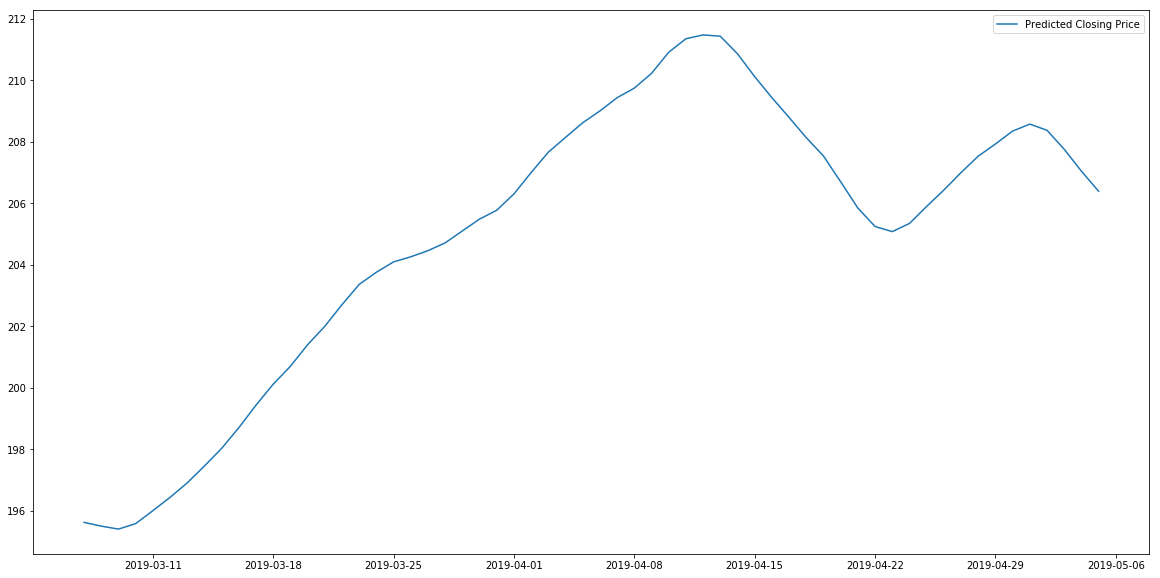

In [34]:
# lets plot the prediction
train = new_data[:]
plt.plot(train,label='Closing Price')
plt.plot(prd,label='Predicted Closing Price')
plt.legend()